<a href="https://colab.research.google.com/github/Adhini99/Ayna-ML-Assignment/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
from google.colab import files
uploaded = files.upload()


Saving dataset.zip to dataset.zip


In [11]:
import zipfile
import os

zip_path = "/content/dataset.zip"
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# List files to verify
!ls /content/dataset/dataset/training/inputs


circle.png   hexagon.png  pentagon.png	star.png
diamond.png  octagon.png  square.png	triangle.png


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [13]:
!pip install wandb


In [14]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as T
import json
import os
import wandb


In [15]:
COLOR_NAME_TO_RGB = {
    "red": (255,0,0),
    "green": (0,255,0),
    "blue": (0,0,255),
    "yellow": (255,255,0),
    "cyan": (0,255,255),
    "magenta": (255,0,255),
    "orange": (255,165,0),
    "purple": (128,0,128)
}


In [16]:
image_transform = T.Compose([
    T.Resize((128,128)),
    T.ToTensor()
])

class PolygonColorizationDataset(Dataset):
    def __init__(self, data_list, input_dir, output_dir, transform=image_transform):
        self.data_list = data_list
        self.input_dir = input_dir
        self.output_dir = output_dir
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        item = self.data_list[idx]
        input_img = Image.open(os.path.join(self.input_dir, item["input_polygon"])).convert("RGB")
        output_img = Image.open(os.path.join(self.output_dir, item["output_image"])).convert("RGB")
        input_tensor = self.transform(input_img)
        output_tensor = self.transform(output_img)
        color_rgb = torch.tensor(COLOR_NAME_TO_RGB[item["colour"].lower()], dtype=torch.float32) / 255.0
        return input_tensor, color_rgb, output_tensor


In [17]:
with open("/content/dataset/dataset/training/data.json", 'r') as f:
    training_data = json.load(f)

with open("/content/dataset/dataset/validation/data.json", 'r') as f:
    validation_data = json.load(f)

train_dataset = PolygonColorizationDataset(
    training_data,
    "/content/dataset/dataset/training/inputs",
    "/content/dataset/dataset/training/outputs"
)

val_dataset = PolygonColorizationDataset(
    validation_data,
    "/content/dataset/dataset/validation/inputs",
    "/content/dataset/dataset/validation/outputs"
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


In [18]:
class UNet(nn.Module):
    def __init__(self, input_channels=3, color_embedding_dim=3, output_channels=3):
        super(UNet, self).__init__()
        self.encoder1 = nn.Sequential(
            nn.Conv2d(input_channels + color_embedding_dim, 64, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = nn.Sequential(
            nn.Conv2d(128,256,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(256,256,3,padding=1),
            nn.ReLU()
        )

        self.up2 = nn.ConvTranspose2d(256,128,2,stride=2)
        self.decoder2 = nn.Sequential(
            nn.Conv2d(256,128,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(128,128,3,padding=1),
            nn.ReLU()
        )

        self.up1 = nn.ConvTranspose2d(128,64,2,stride=2)
        self.decoder1 = nn.Sequential(
            nn.Conv2d(128,64,3,padding=1),
            nn.ReLU(),
            nn.Conv2d(64,64,3,padding=1),
            nn.ReLU()
        )

        self.out_conv = nn.Conv2d(64,output_channels,1)

    def forward(self, x, color_embedding):
        # color_embedding: [B,3]
        B,_,H,W = x.shape
        color_map = color_embedding[:,:,None,None].repeat(1,1,H,W)
        x = torch.cat([x,color_map],dim=1)
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        bottleneck = self.bottleneck(self.pool2(enc2))
        dec2 = self.up2(bottleneck)
        dec2 = torch.cat([dec2,enc2],dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.up1(dec2)
        dec1 = torch.cat([dec1,enc1],dim=1)
        dec1 = self.decoder1(dec1)
        return self.out_conv(dec1)


In [19]:
import wandb
wandb.init(project="aynaml-polygon-colorization")


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: adhini2017 (adhini2017-companycam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

for epoch in range(5):  # Increase epochs as needed
    model.train()
    for x, color, y in train_loader:
        x,y,color = x.to(device), y.to(device), color.to(device)
        pred = model(x,color)
        loss = criterion(pred,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        wandb.log({"train_loss":loss.item()})
    print(f"Epoch {epoch} done")


Epoch 0 done
Epoch 1 done
Epoch 2 done
Epoch 3 done
Epoch 4 done


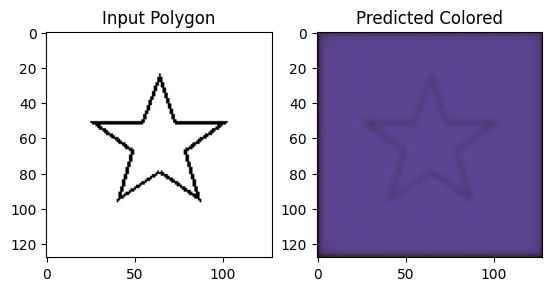

In [21]:
import matplotlib.pyplot as plt

model.eval()
x_batch, color_batch, _ = next(iter(val_loader))
x_batch, color_batch = x_batch.to(device), color_batch.to(device)
with torch.no_grad():
    preds = model(x_batch,color_batch)

# Show one sample
plt.subplot(1,2,1)
plt.imshow(x_batch[0].cpu().permute(1,2,0))
plt.title("Input Polygon")
plt.subplot(1,2,2)
plt.imshow(preds[0].cpu().permute(1,2,0).clamp(0,1))
plt.title("Predicted Colored")
plt.show()


In [22]:
torch.save(model.state_dict(),"unet_colored_polygon.pth")


In [25]:
# test_cases.py

import torch
from torchvision import transforms
from PIL import Image
# from model import UNet # Removed import from non-existent file
# from dataset import color_to_rgb, preprocess_polygon # Removed import from non-existent file
import os

# Load model
model = UNet()
# Update the path to the saved model
model.load_state_dict(torch.load("/content/unet_colored_polygon.pth", map_location='cpu'))
model.eval()

# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Define test inputs (using data from the validation set)
test_cases = [
    ("/content/dataset/dataset/validation/inputs/triangle.png", "blue"),
    ("/content/dataset/dataset/validation/inputs/square.png", "red"),
    ("/content/dataset/dataset/validation/inputs/octagon.png", "green"),
]

os.makedirs("outputs", exist_ok=True)

# Use the COLOR_NAME_TO_RGB dictionary defined in a previous cell
color_to_rgb = COLOR_NAME_TO_RGB

for i, (img_path, color_name) in enumerate(test_cases):
    polygon_img = Image.open(img_path).convert("RGB") # Changed to RGB to match model input
    polygon_tensor = transform(polygon_img).unsqueeze(0)

    # Reshape color tensor to match the expected input shape [B, 3]
    color_tensor = torch.tensor(color_to_rgb[color_name], dtype=torch.float32) / 255.0
    color_tensor = color_tensor.unsqueeze(0) # Add batch dimension

    # The model expects the color_embedding to be [B, 3], not [B, 3, H, W]
    with torch.no_grad():
        output = model(polygon_tensor, color_tensor)

    out_img = transforms.ToPILImage()(output.squeeze(0).clamp(0,1)) # Added clamp to ensure valid pixel values
    out_img.save(f"outputs/output_case_{i+1}_{color_name}.png")

print("✅ Test cases completed. Outputs saved in 'outputs/'")

✅ Test cases completed. Outputs saved in 'outputs/'
